In [1]:
import pandas as pd
import re
import ast

In [2]:
def load_tsv(file): return pd.read_csv(file, sep="\t", na_values='\\N', dtype=str)
def cleanCharactersFromPrincipal(characters):
    if not isinstance(characters, str): 
        return "not available"
    try:
        parsed = ast.literal_eval(characters)
        if isinstance(parsed, list) and parsed:
            first = parsed[0]
            if isinstance(first, str):  # ensure it's a string
                cleaned = re.sub(r"[^A-Za-z0-9 ]+", "", first)
                return cleaned.strip()
    except Exception:
            return "not available"

In [3]:
basics = load_tsv("data/title.basics.tsv")
ratings = load_tsv("data/title.ratings.tsv")
crew = load_tsv("data/title.crew.tsv")
principals = load_tsv("data/title.principals.tsv")
names = load_tsv("data/name.basics.tsv")    

In [4]:
basics = basics[basics['titleType'] == 'movie']
basics['startYear'] = pd.to_numeric(basics['startYear'], errors='coerce')
ratings['averageRating'] = pd.to_numeric(ratings['averageRating'], errors='coerce')
ratings['numVotes'] = pd.to_numeric(ratings['numVotes'], errors='coerce')
basics_merged = basics.merge(ratings, on='tconst').merge(crew, on='tconst')

In [5]:
#clean principal data
#principals[principals['category'].isin(['actor', 'actress'])]
movie_titles = set(basics_merged[basics_merged['titleType'] == 'movie']['tconst'])
principals_new = principals[principals['tconst'].isin(movie_titles)]
principals_new = principals_new.drop(columns='job')
#Remove "self" categories
principals_new = principals_new[principals_new["category"].str.lower() != "self"]
#clean the chracters column to use it further
principals_new = principals_new[principals_new["characters"].notna()]
principals_new["characters"] = principals_new["characters"].apply(cleanCharactersFromPrincipal)
principals_new = principals_new[principals_new['category'].isin(['actor', 'actress'])]
principals_new = principals_new.dropna().reset_index(drop=True)
names_df = names[['nconst','primaryName']]
principals_new = principals_new.merge(names_df, on='nconst')
principals_new

,tconst,ordering,nconst,category,characters,primaryName
0,tt0000009,1,nm0063086,actress,Miss Geraldine Holbrook Miss Jerry,Blanche Bayliss
1,tt0000009,2,nm0183823,actor,Mr Hamilton,William Courtenay
2,tt0000009,3,nm1309758,actor,Chauncey Depew the Director of the New York C...,Chauncey Depew
3,tt0000574,1,nm0846887,actress,Kate Kelly,Elizabeth Tait
4,tt0000574,2,nm0846894,actor,School Master,John Tait
...,...,...,...,...,...,...
2170386,tt9916538,7,nm2999289,actor,Parjo,Ence Bagus
2170387,tt9916538,8,nm4774809,actor,Mbah Jiwo,T.M. Tarsan
2170388,tt9916538,9,nm3369416,actress,Nenek,Yati Pesek
2170389,tt9916538,10,nm3370435,actor,Brel,Marwoto


In [6]:
basics_merged[basics_merged['tconst'] == 'tt0111161']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
62848,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994.0,NaN,142,Drama,9.3,3038716,nm0001104,"nm0000175,nm0001104"


In [7]:
def get_actors(tconst):
    actDetails=[]
    actors = principals_new[(principals_new['tconst'] == tconst)]
    for _, row in actors.iterrows():
        actDetails.append(f'Character "{row['characters']}" played by {row['category']} "{row['primaryName']}"')
    return('"' + ", ".join(actDetails) + '"')

def get_names(ids, name_df):
    if pd.isnull(ids): return []
    return name_df[name_df['nconst'].isin(ids.split(','))]['primaryName'].dropna().tolist()

In [8]:
import pandas as pd

def get_names(ids, name_df):
    if pd.isnull(ids): return "data not available"
    newList = name_df[name_df['nconst'].isin(ids.split(','))]['primaryName'].dropna().tolist()
    return ('"' + ", ".join(newList) + '"')

def get_actors(tconst):
    actDetails=[]
    actors = principals_new[(principals_new['tconst'] == tconst)]
    for _, row in actors.iterrows():
        actDetails.append(f'Character "{row['characters']}" played by {row['category']} "{row['primaryName']}"')
    return('"' + ", ".join(actDetails) + '"')

def build_movie_records():  
    df = basics_merged[basics_merged['numVotes'] >= 5000].sort_values('averageRating', ascending=False)
    final_data ={}
    records = []
    for _, row in df.iterrows():
        tconst = row["tconst"]
        title = row["primaryTitle"]
        year = int(row["startYear"]) if pd.notnull(row["startYear"]) else 'not available'
        genres = row["genres"]
        averageRating = row["averageRating"]
        numVotes = row["numVotes"]
        directors = get_names(row["directors"], names)
        writers = get_names(row["writers"], names)
        runtime = row['runtimeMinutes']
        topActors = get_actors(row["tconst"])
        
        parts = [f'Movie "{title}" released in year ({year})']
        if genres:
            parts.append(f"is a {genres} film")
        if directors:
            parts.append(f"directed by {directors}")
        if writers:
            parts.append(f"written by {writers}")
        if runtime:
            parts.append(f"with a runtime of {runtime} minutes")
        if averageRating:
            parts.append(f"rated {averageRating}/10 on IMDb")
        if numVotes:
            parts.append(f"based on {numVotes} votes.")
        if topActors:
            parts.append(f"The top casting is as follow : {topActors}")
            
        #records.append('"' + ", ".join(parts) + '"')
        final_data[row["tconst"]] = ", ".join(parts)
        
    return final_data


In [9]:
records = build_movie_records()
df = pd.DataFrame(records.items(), columns=["mov_id", "mov_details"])
df.to_csv('movies.csv',index=False)

In [10]:
mymovies = pd.read_csv('movies.csv')


In [11]:
mymovies

,mov_id,mov_details
0,tt0111161,"Movie ""The Shawshank Redemption"" released in y..."
1,tt21272942,"Movie ""The Strangers' Case"" released in year (..."
2,tt0068646,"Movie ""The Godfather"" released in year (1972),..."
3,tt1114271,"Movie ""Thursday"" released in year (2006), is a..."
4,tt33175825,"Movie ""Attack on Titan the Movie: The Last Att..."
...,...,...
17786,tt7886848,"Movie ""Sadak 2"" released in year (2020), is a ..."
17787,tt35295730,"Movie ""A Business Proposal"" released in year (..."
17788,tt13423846,"Movie ""321 Action"" released in year (2020), is..."
17789,tt7221896,"Movie ""Cumali Ceber"" released in year (2017), ..."


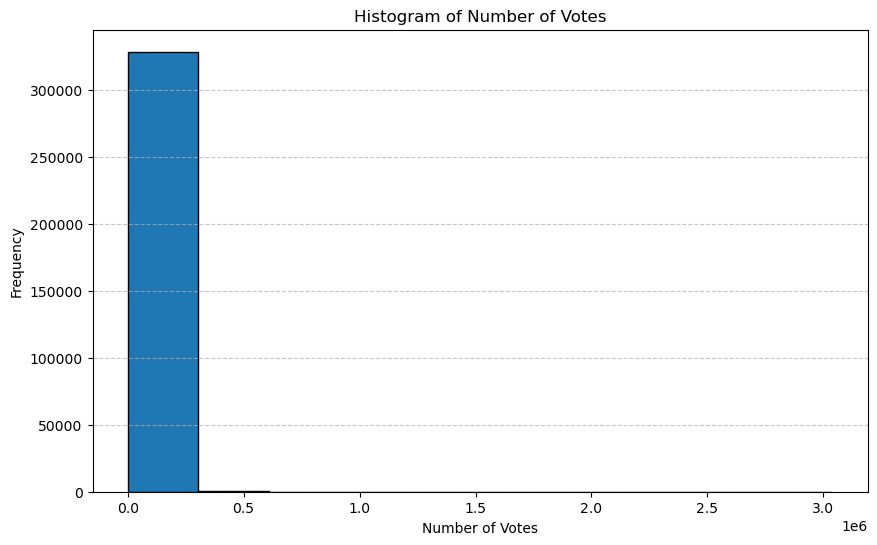

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(basics_merged['numVotes'], bins=10, edgecolor='black') 
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Votes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
bins = [0, 2500, 5000, 10000, 25000, 50000, 75000, 100000, 200000, 500000, basics_merged['numVotes'].max()]
labels = [
    '0-2,500',
    '2,501-10,000',
    '5,001-10,000',
    '10,001-25,000',
    '25,001-50,000',
    '50,001-75,000',
    '75,001-100,000',
    '100,001-200,000',
    '200,001-500,000',
    f'500,001-{basics_merged["numVotes"].max()}'
]

basics_merged['vote_zone'] = pd.cut(basics_merged['numVotes'], bins=bins, labels=labels, include_lowest=True)

zone_counts = basics_merged['vote_zone'].value_counts().sort_index()

print(zone_counts)


vote_zone
0-2,500            302534
2,501-10,000         9147
5,001-10,000         6015
10,001-25,000        4956
25,001-50,000        2440
50,001-75,000        1146
75,001-100,000        668
100,001-200,000      1294
200,001-500,000       925
500,001-3038716       346
Name: count, dtype: int64


In [14]:
basics_merged[basics_merged['numVotes'] >= 5000].sort_values('averageRating', ascending=False)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,vote_zone
62848,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994.0,NaN,142,Drama,9.3,3038716,nm0001104,"nm0000175,nm0001104","500,001-3038716"
224549,tt21272942,movie,The Strangers' Case,The Strangers' Case,0,2024.0,NaN,103,Drama,9.3,8354,nm4036280,nm4036280,"5,001-10,000"
37833,tt0068646,movie,The Godfather,The Godfather,0,1972.0,NaN,175,"Crime,Drama",9.2,2121123,nm0000338,"nm0701374,nm0000338","500,001-3038716"
161787,tt1114271,movie,Thursday,Thursday,0,2006.0,NaN,89,"Action,Adventure,Crime",9.2,5374,nm2792443,"nm2793149,nm2629400","5,001-10,000"
265273,tt33175825,movie,Attack on Titan the Movie: The Last Attack,Shingeki no Kyojin: The Last Attack,0,2024.0,NaN,145,"Action,Adventure,Animation",9.2,15934,nm3210514,nm4697729,"10,001-25,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316118,tt7886848,movie,Sadak 2,Sadak 2,0,2020.0,NaN,133,"Action,Drama",1.2,96980,nm0080315,"nm10023062,nm0080315,nm10114557","75,001-100,000"
270230,tt35295730,movie,A Business Proposal,A Business Proposal,0,2025.0,NaN,117,"Comedy,Drama,Romance",1.0,22475,nm1266812,"nm12822346,nm2680903","10,001-25,000"
180598,tt13423846,movie,321 Action,321 Action,0,2020.0,NaN,100,Drama,1.0,10243,nm8565031,nm7842264,"10,001-25,000"
310608,tt7221896,movie,Cumali Ceber,Cumali Ceber,0,2017.0,NaN,100,Comedy,1.0,39576,nm9107963,nm9107965,"25,001-50,000"
